# Deep Learning Challenge


## The assignment

Below we provide the code to train a network to classify the number of dwellings in a certain part of an aerial image. Can you outperform the network below on our grid statistics problem? What will you do? Tweak the parameters of the network? Change the network structure? Or will you provide the algorithm with more annotated data? Remember the big four??


1) Dataset: in principle all types of data can be processed (e.g., numerical, text, images, sound and even videos)

2) Loss function: a function that indicates how well our model solves a given problem (e.g., categorical or binary crossentropy, etc.)

3) Optimizer: the process of searching for parameters that minimize loss functions (e.g, stochastic gradient descent, RMSProp, Adagrad, etc.)

4) Network structure: the depth and design of the layers!

To improve network performance, you need to change aspects of the big four. You can change the dataset to include more pictures for example, you can use a different optimizer, or you can change the structure of your neural network. Below we will describe the training of a convolutional neural network on an image dataset in terms of the big four. In each step, we will show you how to carry out that step, but we will also give you ideas how to change aspects of or tune that step to get better network performance. Let's get started!

## 1. The Dataset

First we will load our dataset from disk. We prepared the dataset already for you by cutting up the aerial picture in a grid. Every image represents an area of 100x100m, or 40x40 pixels. We also already labeled the data and split it up in a training and a test set. We labeled the data by taking the amount of houses in every picture and splitting them into two quantiles (number of houses smaller and larger than the median). In short, each image thus has a label 0 or 1. The images are also split into a training set (75%) present in the train directory and a test set (25%) in the test directory. Both directories have 2 subdirectories, each of which contain the images belonging to a certain quantile.

To load the pictures we are using the Keras ImageDataGenerator, a handy tool to load the images from disk and assign them a label based on the subdirectory. An image in the train/0 directory gets a label of 0, whereas an image in the train/1 directory gets a label of 1. The same, of course, applies for the images in the test directory.

In [9]:
import os

# Download the data from our GitLab page
!rm -rf DeepStat/
!wget https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/DeepStat.zip
!unzip DeepStat.zip

data_directory = os.path.join('/content/')

--2023-11-21 10:36:38--  https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/DeepStat.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14839261 (14M) [application/octet-stream]
Saving to: ‘DeepStat.zip.2’

DeepStat.zip.2      100%[===================>]  14.15M  38.9MB/s    in 0.4s    

2023-11-21 10:36:39 (38.9 MB/s) - ‘DeepStat.zip.2’ saved [14839261/14839261]

Archive:  DeepStat.zip
   creating: DeepStat/
   creating: DeepStat/test/
   creating: DeepStat/test/0/
  inflating: DeepStat/test/0/E0326N3910_rgb_2017_lr.tiff  
  inflating: DeepStat/test/0/E0445N3828_rgb_2017_lr.tiff  
  inflating: DeepStat/test/0/E0463N3728_rgb_2017_lr.tiff  
  inflating: DeepStat/test/0/E0465N3945_rgb_2017_lr.tiff  
  inflating: DeepStat/test/0/E0480N3724_rgb_2017_lr.tiff  
  inflating: DeepStat/test/0/E0483N4019_rgb_2017_lr.tiff  
  i

In [10]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

batch_size = 64

train_gen = ImageDataGenerator(rescale=1/255.)
train_generator = train_gen.flow_from_directory(os.path.join(data_directory, "DeepStat/train"), target_size=(40, 40), batch_size=batch_size)
number_of_train_examples = len(train_generator.filenames)

test_gen = ImageDataGenerator(rescale=1/255.)
test_generator = test_gen.flow_from_directory(os.path.join(data_directory, "DeepStat/test"), target_size=(40, 40), batch_size=batch_size)
number_of_test_examples = len(test_generator.filenames)


Found 2250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


We can see that we have 3000 images in total. 2250 images in the training set, and 750 images in the test set. We see that both the training set and the test set have 2 classes each, corresponding to the quartiles. Because we are using quartiles to label the images, each label should have almost the same amount of images assigned to it.

In [11]:
from sklearn.utils import class_weight
import os

num_categories = 2
available_categories = np.linspace(0, num_categories-1, num_categories)

images_per_category = {int(category) : [image for image in os.listdir(os.path.join(data_directory, f"DeepStat/train/{int(category)}"))] for category in available_categories}

for category, images in images_per_category.items():
    print(f"Number of images in category {category}: {len(images)}")


Number of images in category 0: 1341
Number of images in category 1: 909


As we can see the number of images per quantile are different. To balance the influence each category has when training the network, we therefore use class_weights for each class. We can calculate the class weights as follows. You can see that the class weights for the last category is big bigger than the one for the first. The last category contains less images and is therefore given a bigger weight during training; each separate image has a bit more influence on the end result.

In [12]:
y_train = np.array([category for category, images in images_per_category.items() for _ in images ])

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=available_categories,
                                                 y=y_train)
class_weights


array([0.83892617, 1.23762376])

### Tips to improve network performance

To improve network performance by means of the dataset, often more data means better performance. In this case, however, you already have a dataset and no way to add more examples. Another way to add more examples, without creating more images, is using data augmentation. In our case we specifically need image data augmentation, which means that we create more examples based on the images we already have. We can do that by rotating, scaling, mirroring images, changing image color, etc. The same ImageDataAugmentation class that we use to load the images, can be used to create extra artificial images. Try to experiment with ImageDataAugmentation and see what it does with network performance. To see a list of available options, visit the keras documentation [here](https://keras.io/api/preprocessing/image/).

**Note:** You only use image data augmentation during training, when you would like to have as many examples as possible!

## 2. The Optimizer

The optimizer trains our network. It changes the network weights, and minimizes the loss given by the loss function. A lot of different optimizers exists, the most standard and common one called stochastic gradient descent or SGD. All other optimizers are specializations of SGD that update the weights in a different manner, using specific rules. While SGD allows you to configure learning almost completely to your own wishes, other optimizers tune hyperparameters more automatically and are often more simple to tune. Each optimizer has a list of hyperparameters that influence training behavior. To see a list of available optimizers and their hyperparameters, visit the keras documentation [here](https://keras.io/api/optimizers/).

### Tips to improve network performance

While stochastic gradient descent gives you a lot of flexibility, it also gives you a lot of hyperparameters that you need to tune manually. To start a bit more simple, try one of the optimizers that are more automatic like RMSprop or the Adam based optimizers. See the Keras documentation for possible optimizers and hyperparameters that can be tuned.

In [13]:
from tensorflow.keras.optimizers.legacy import SGD, Adadelta, Adagrad, RMSprop

lr = 0.01
optimizer = SGD(lr=lr, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## 3. The loss function

The loss function calculates a loss on the basis of the difference between the actual label, and the output of the network. The loss function therefore highly depends on the type of labels you have. In our case, we are training a network for classification and the loss function depends on the number of categories you have. For a binary classification problem, with two classes, often BinaryCrossEntropy is used. For a classification problem with more than two classes, like we are having here, we often use CategoricalCrossEntropy. Because changing the loss function depends on your problem, not every loss function works with every dataset. Therefore, before changing the loss function, check which ones are applicable for our problem. To see a list of available loss functions, visit the keras documentation [here](https://keras.io/api/losses/probabilistic_losses/).

## 4. The Network structure

The last thing we can change is the structure of the convolutional neural network. We can change the network structures in a lot of different ways, as long as we keep the Input layer and the last Dense layer, the softmax layer, in place. Almost, everything else in between can be changed. For example, we can change the number of layers a network has, but we can also change the type of layers, or the order in which certain types of layers follow each other. We can also change the activation functions and add layers which are called regularizers, like for example L2 regularization, BatchNormalization, or Dropout. Such layers influence the network weights during training to try and make them more robust to changes in the output. To see a list of available layers, activation functions, regularizers, etc., visit the keras documentation [here](https://keras.io/api/layers/).

### Tips to improve network performance

A first tip: while changing network structure keep in mind the sizes of the subsequent layers, which you can check with the `model.summary()` method: if the last layer size just before the softmax layer are to big, it is difficult for the network to learn, because it has a lot of information it needs to digest. Conversely, it the last layer is to small, it does not have enough information to learn from.

Another tip is not trying to reinvent the wheel; it is often difficult to come up with entirely new network structures, so look at proven network structures and see if you can borrow from them. See for example below a convolutional block from a well-known network called VGG16. Neural networks are often build from such blocks, which can easily be reused and adapted to a specific problem. Keep in mind the first tip, adding more or less blocks influences the sizes in the last layers before the softmax layer.

**Note:** While you can change a lot of layers, we will always need Conv2D layers to learn the spatial structures in the image. We will also need some pooling layers, or strides to gradually bring the image sizes back to some higher level features that can be classified into our categories.

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers

def vgg16_block_conv2(x, layer_depth, block_name):
    x = Conv2D(layer_depth, (3, 3), activation="relu", padding="same", name=("%s_conv1" % block_name))(x)
    x = Conv2D(layer_depth, (3, 3), activation="relu", padding="same", name=("%s_conv2" % block_name))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=("%s_pool" % block_name))(x)
    return x

input_layer = Input(shape=(40, 40, 3))
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D((3, 3), strides=(3, 3))(x)
x = Flatten()(x)
predictions = Dense(num_categories, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(input_layer, predictions)
model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 10818     
                                                                 
Total params: 11714 (45.76 KB)
Trainable params: 11714 (45.76 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

When we have our dataset, optimizer, loss function, and convolutional neural network, we can start training. The first thing we can change during training is the batch_size. The batch_size is the sample size of the training set that is given to the network at once for training. The smaller the batch_size, the smaller the sample, and the bigger the chance of having a sample that does not reflect the target population. The larger the batch_size, the less updates you have, and the longer training can take. Also the chances of running out of memory increase. Finding the right batch_size is therefore finding the right balance between a small and a larger sample. Typical batch_sizes range from 32, 64, to 128. For efficiency, they are almost always a power of 2.

Another thing we can change during training is the number of epochs the training is run. The number of epochs determines the number of iterations the model is trained. More epochs means longer training, and sometimes results in a better model performance. Other times, however, model performance stagnates after a certain amount of epochs. It then does not make much sense to continue training. For these scenarios, it is handy to look at so-called [early stopping](https://keras.io/api/callbacks/early_stopping/), that, among ohters, can stop training after the model performance has stagnated for a couple of epochs.

**Note:** the batch_size was defined in the start of this notebook, because the ImageDataGenerator also needs it to determine how many images should be loaded at a time.

In [15]:
epochs = 10

H_cnn = model.fit(train_generator,  steps_per_epoch=number_of_train_examples/batch_size, epochs=epochs, verbose=1, validation_data=test_generator, validation_steps=number_of_test_examples/batch_size)

Epoch 1/10
35/35 [==============================] - 3s 65ms/step - loss: 0.7239 - accuracy: 0.5951 - val_loss: 0.7229 - val_accuracy: 0.5693
Epoch 2/10
35/35 [==============================] - 2s 59ms/step - loss: 0.7101 - accuracy: 0.5982 - val_loss: 0.7138 - val_accuracy: 0.5693
Epoch 3/10
35/35 [==============================] - 3s 81ms/step - loss: 0.7052 - accuracy: 0.5991 - val_loss: 0.7075 - val_accuracy: 0.5693
Epoch 4/10
35/35 [==============================] - 2s 62ms/step - loss: 0.7010 - accuracy: 0.6027 - val_loss: 0.7053 - val_accuracy: 0.5693
Epoch 5/10
35/35 [==============================] - 2s 60ms/step - loss: 0.6861 - accuracy: 0.6067 - val_loss: 0.6883 - val_accuracy: 0.6067
Epoch 6/10
35/35 [==============================] - 2s 58ms/step - loss: 0.6761 - accuracy: 0.6187 - val_loss: 0.6734 - val_accuracy: 0.5840
Epoch 7/10
35/35 [==============================] - 2s 59ms/step - loss: 0.6711 - accuracy: 0.6240 - val_loss: 0.6854 - val_accuracy: 0.5693
Epoch 8/10
35

## Evaluating the training process

To see if the training process went right, it is important to observe the development of the loss function on the training set and the validation set. In addition, we also need to observe the development of the metric we would like to optimize, in this case the categorical accuracy. If training went well, the loss should decrease and the categorical accuracy should increase. Moreover, the loss on the training set should have a similar development as the loss on the validation set. To check for overfitting or underfitting, we plot the loss and the categorical accuracy for both the training set and the validation set. To see how use learning curves to diagnose machine learning model performance, read the following [article](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

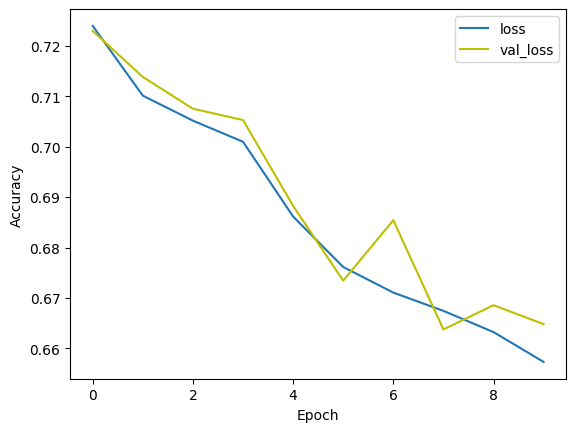

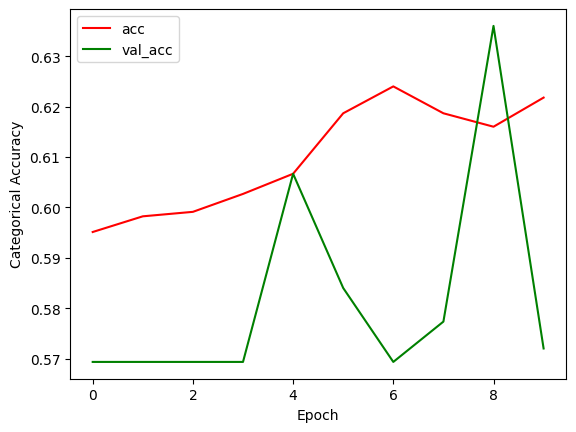

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(np.arange(0, epochs), H_cnn.history["loss"], label="loss")
plt.plot(np.arange(0, epochs), H_cnn.history["val_loss"], color="y", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")


plt.figure()
plt.plot(np.arange(0, epochs), H_cnn.history["accuracy"], color="r", label="acc")
plt.plot(np.arange(0, epochs), H_cnn.history["val_accuracy"], color="g", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.legend(loc="best")

## Evaluating model performance

Last, the code below evaluates how well the model performs on the test set. For that, we first have to retrieve all the ground-truth labels for the test set: the true labels that should have been predicted. After that, we can compare the true labels to the predictions and see whether the model has predicted the label correctly.

In [17]:
#Get test labels from generator
test_labels = []
test_images = []

print(f"number_of_test_examples: {number_of_test_examples}")
print(f"batch_size: {batch_size}")
print(f"int(number_of_test_examples/batch_size): {int(number_of_test_examples/batch_size)}")

for i in range(0,int(number_of_test_examples/batch_size)+1):
    test_labels.extend(np.array(test_generator[i][1]))
    test_images.extend(np.array(test_generator[i][0]))

np_test_labels = np.array(test_labels)
np_test_labels.shape

number_of_test_examples: 750
batch_size: 64
int(number_of_test_examples/batch_size): 11


(750, 2)

To evaluate machine learning model performance a lot of different metrics exist. Here we are using the sklearn classification_report that print some of the most widely used metrics for each category that we are training on. For a more exhaustive list of metrics see [here](https://en.wikipedia.org/wiki/Precision_and_recall) or the [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

**Note:** in the example presented here, we have a fairly balanced dataset, that means we almost have the same number of images per category, so we can use metrics like accuracy, precision, and f1-score. In the case that we have a more imbalanced dataset, these metrics will not give good estimates of network performance and we should instead look at their balanced counterparts.

In [18]:
from sklearn.metrics import classification_report

predictions_model = model.predict(test_generator, steps=number_of_test_examples/batch_size)
print(classification_report(np_test_labels.argmax(axis=1), predictions_model.argmax(axis=1)))

11/11 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       427
           1       0.54      0.05      0.09       323

    accuracy                           0.57       750
   macro avg       0.55      0.51      0.40       750
weighted avg       0.56      0.57      0.45       750



## Visualizing the Predictions

Next to evaluating model performance, it is also always a good idea to visualize network predictions, along with their true labels. In this way, we can identify cases that go well, but we can also identify cases that go wrong.
As seen below, sometimes a model prediction is completely off. But in other cases, it may be difficult for a model to predict the correct label. Especially, since a human observer would predict a similar label.

You can explore the model predictions for each category below, by changing the true label in the drop down box. Then the images for that true label with their predictions will be plotted.

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from ipywidgets import interact, widgets
import math

images_per_page = 16

def page(images, page_index, items_per_page):
    return [images[i:i+items_per_page] for i in range(0, len(images), items_per_page)][page_index]

def filter_images(test_images, test_labels, predictions_model, filter_label):
    all_images = zip(test_images, test_labels, predictions_model)
    return [(image, label, prediction) for image, label, prediction in all_images if label.argmax() == filter_label]

def plot_images(test_images, test_labels, predictions_model, filter_label, page_index, images_per_page):
    fig = plt.figure(figsize=(12., 12.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.3,
                 )

    images_for_label = filter_images(test_images, test_labels, predictions_model, filter_label)
    images_for_page = page(images_for_label, page_index, images_per_page)
    for ax, (image, true_label, prediction) in zip(grid, images_for_page):
        ax.imshow(image)
        label_color = 'g' if true_label.argmax() == prediction.argmax() else 'r'
        ax.set_title(f"true: {true_label.argmax()}, predicted: {prediction.argmax()}", backgroundcolor=label_color)

    plt.show()

def plot_images_for_labels(true_label, page_index):
    plot_images(test_images=test_images, test_labels=test_labels, predictions_model=predictions_model, filter_label=true_label, page_index=page_index, images_per_page=16)

true_label_widget = widgets.Dropdown(options=available_categories)
page_widget = widgets.Dropdown()

def update(*args):
    images_for_label = filter_images(test_images, test_labels, predictions_model, true_label_widget.value)
    number_of_pages = math.ceil(len(images_for_label) / images_per_page)
    page_widget.options = range(number_of_pages)
    page_widget.value = 0

true_label_widget.observe(update)

interact(plot_images_for_labels, true_label=true_label_widget, page_index=page_widget);

interactive(children=(Dropdown(description='true_label', options=(0.0, 1.0), value=0.0), Dropdown(description=…